In [2]:
#Load the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing import image as keras_image


In [3]:
data_dir = 'Preprocessed_Dataset/'
class_folders = os.listdir(data_dir)
folder_counts = []
for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    image_files = os.listdir(class_path)
    folder_counts.append({'Plant Name': class_folder, 'Image Count': len(image_files)})

In [4]:
df = pd.DataFrame(folder_counts)

In [5]:
df

,Plant Name,Image Count
0,Healthy-fenugreek,1575
1,powdery-mildew-fenugreek,1589
2,spinach-Cladosporium_Leaf_spot,189
3,spinach-healthy,1274
4,new-alternaria,5432


In [6]:
import tensorflow as tf

# Check if TensorFlow is using a GPU
gpu_available = tf.config.list_physical_devices('GPU')
is_using_gpu = len(gpu_available) > 0

print("Is using GPU:", is_using_gpu)


Is using GPU: False


In [7]:
len(gpu_available)

0

In [8]:
df.to_excel('plant_disease_count.xlsx')

path of the image:  Preprocessed_Dataset/Healthy-fenugreek/20240316_204948_crop_rotated_flipped.png
label of the certain image:  Healthy-fenugreek
Found 7041 validated image filenames belonging to 5 classes.
Found 302 validated image filenames belonging to 5 classes.
Found 2716 validated image filenames belonging to 5 classes.


2024-07-16 17:56:24.575108: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/60


2024-07-16 17:56:26.128929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


177/177 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.5677

2024-07-16 18:06:45.094347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


177/177 [==============================] - 636s 4s/step - loss: 1.1470 - accuracy: 0.5677 - val_loss: 1.0526 - val_accuracy: 0.5430
Epoch 2/60
177/177 [==============================] - 607s 3s/step - loss: 0.7289 - accuracy: 0.7309 - val_loss: 0.9611 - val_accuracy: 0.6159
Epoch 3/60
177/177 [==============================] - 640s 4s/step - loss: 0.5920 - accuracy: 0.7777 - val_loss: 0.9177 - val_accuracy: 0.6192
Epoch 4/60
177/177 [==============================] - 602s 3s/step - loss: 0.5101 - accuracy: 0.8051 - val_loss: 0.8330 - val_accuracy: 0.6589
Epoch 5/60
177/177 [==============================] - 603s 3s/step - loss: 0.4585 - accuracy: 0.8205 - val_loss: 0.6228 - val_accuracy: 0.7285
Epoch 6/60
177/177 [==============================] - 614s 3s/step - loss: 0.4259 - accuracy: 0.8301 - val_loss: 0.5396 - val_accuracy: 0.7517
Epoch 7/60
177/177 [==============================] - 598s 3s/step - loss: 0.4074 - accuracy: 0.8353 - val_loss: 0.4953 - val_accuracy: 0.7914
Epoch 8/60

2024-07-17 04:10:46.146689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


68/68 [==============================] - 145s 2s/step - loss: 0.1630 - accuracy: 0.9245
Test Loss: 0.16301916539669037
Test Accuracy: 0.9245213270187378


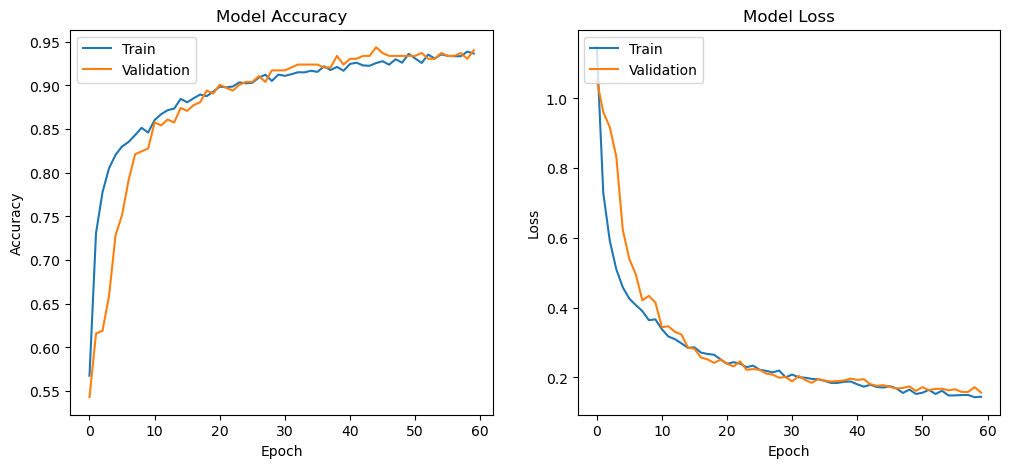

In [9]:
data_dir = 'Preprocessed_Dataset/'
class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image_paths.append(image_path)
        labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
print('path of the image: ',df.loc[1]['image_path'])
print('label of the certain image: ',df.loc[1]['label'])
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.1, stratify=test_df['label'], random_state=42)


batch_size = 40

train_datagen = ImageDataGenerator(

    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
class_labels_dict = {class_label: idx for idx, class_label in enumerate(np.unique(df['label']))}
num_classes = len(class_labels_dict)
from tensorflow.keras.layers import Layer, Attention, Dropout  # Add Dropout import  
from tensorflow.keras.optimizers import Adam
import tensorflow as tf  
import numpy as np
# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
          super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):

        self.w_q = self.add_weight(name='q_kernel',    
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='uniform',
                                  trainable=True)

        self.w_k = self.add_weight(name='k_kernel',
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='uniform',
                                  trainable=True)

        self.w_v = self.add_weight(name='v_kernel',
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='uniform',
                                  trainable=True)

        super(SelfAttention, self).build(input_shape)

    def call(self, x):    
        q = tf.matmul(x, self.w_q)
        k = tf.matmul(x, self.w_k)
        v = tf.matmul(x, self.w_v)
        attn_scores = tf.matmul(q, k, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores, axis=-1)
        output = tf.matmul(attn_scores, v)
        return output


# MobileNetV2 with attention mechanism

base_model = MobileNetV2(weights='imagenet', include_top=False)   
x = base_model.output
x = SelfAttention()(x)  # Add the attention mechanism layer here
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Include the Dropout layer
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Unfreeze more layers in the MobileNetV2 model
n = 40
for layer in model.layers[:-n]:
      layer.trainable = True

# Adjust the learning rate for fine-tuning
learning_rate_finetune = 0.00001
# Compile the model with the updated learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate_finetune), loss='categorical_crossentropy', metrics=['accuracy'])
# Fine-tuning
epochs_finetune = 60
history_finetune = model.fit(train_generator, epochs=epochs_finetune, validation_data=val_generator)
# After training, you can evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# Save the Fine-tuned Model
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the figure
plt.savefig('accuracy_loss_graph_'+'.png')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming test_generator has shuffle=False
# Predict the classes with the model
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Getting the labels from the generator

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Function to calculate sensitivity and specificity
def sensitivity_specificity(cm, class_idx):
    # Sensitivity (Recall or True Positive Rate) for class class_idx
    sensitivity = cm[class_idx, class_idx] / cm[class_idx, :].sum()
    
    # Specificity (True Negative Rate) for class class_idx
    true_negative = np.delete(np.delete(cm, class_idx, axis=0), class_idx, axis=1).sum()
    false_positive = np.delete(cm[class_idx, :], class_idx).sum()
    specificity = true_negative / (true_negative + false_positive)
    
    return sensitivity, specificity

# Calculate sensitivity and specificity for each class
for i, class_label in enumerate(class_labels):
    sens, spec = sensitivity_specificity(cm, i)
    print(f'Class: {class_label} - Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}')



2024-03-26 18:45:29.708773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 31s 2s/step
Class: Healthy-fenugreek - Sensitivity (Recall): 0.9421, Specificity: 0.9875
Class: new-alternaria - Sensitivity (Recall): 0.8854, Specificity: 0.7992
Class: powdery-mildew-fenugreek - Sensitivity (Recall): 0.5246, Specificity: 0.8972
Class: spinach-Cladosporium_Leaf_spot - Sensitivity (Recall): 0.6667, Specificity: 0.9925


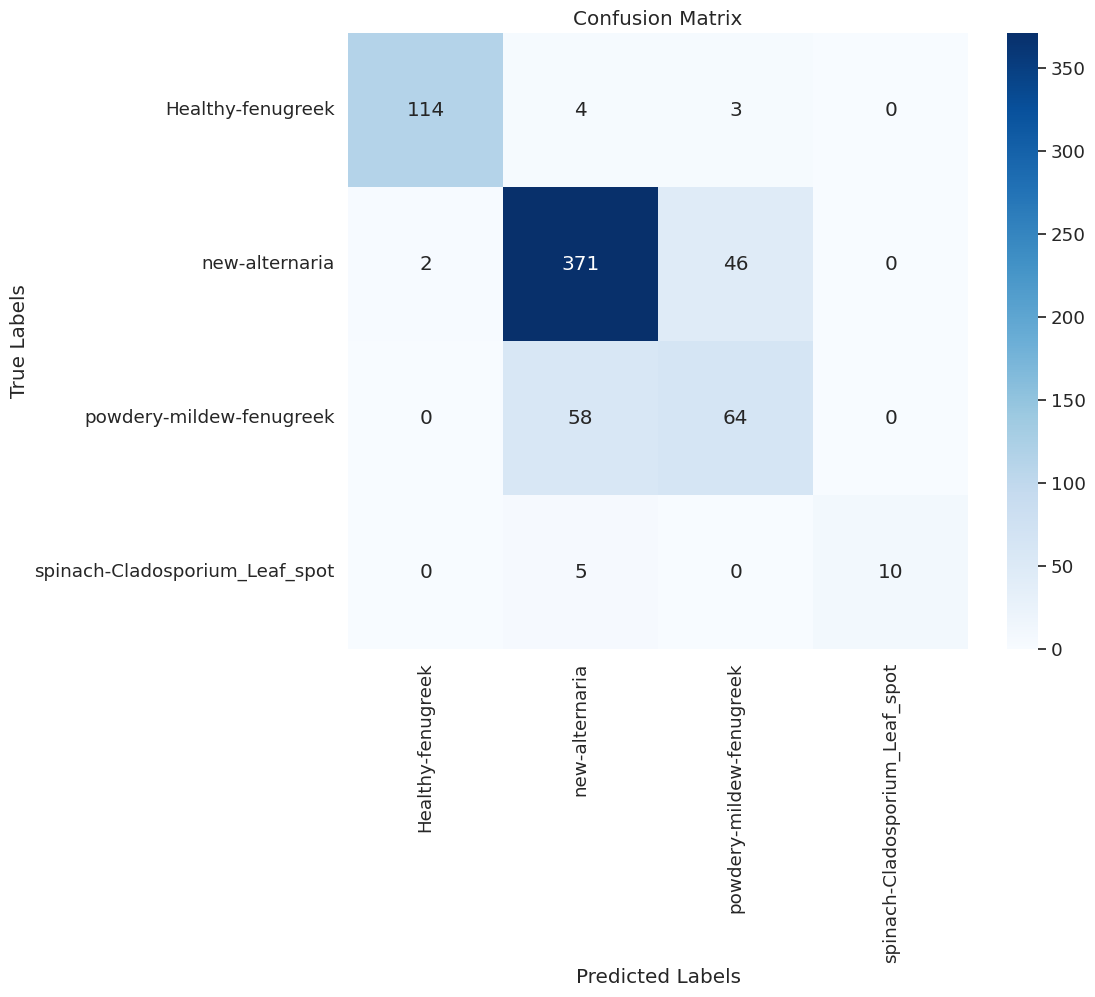

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cm is your confusion matrix and class_labels are the labels of your classes
sns.set(font_scale=1.2) # This is optional and can be adjusted to fit your need
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Adding the aesthetics
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


In [8]:
model.save('second_multiclass_model.h5')

In [10]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [ ]:
df = pd.read_parquet(TRAIN[0])
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [6]:
import os
from PIL import Image
import numpy as np
# Define your source and destination directories
source_dir = 'Original_Dataset'
destination_dir = 'Preprocessed_Dataset'

# Preprocessing function
from PIL import Image, ImageEnhance, ImageFilter

def preprocess_image(input_path, output_path, resize_dim=(256, 256), grayscale=False, normalize=False, crop_box=None, rotate_angle=None, flip=False, color_adjust=None, filter_type=None):
    # Open the image
    image = Image.open(input_path)
    
    # Resize the image
    image = image.resize(resize_dim)
    
    # Convert to grayscale if required
    if grayscale:
        image = image.convert('L')
    
    # Normalize if required
    if normalize:
        image = np.asarray(image) / 255.0
        image = Image.fromarray((image * 255).astype(np.uint8))
    
    # Crop the image if crop_box is provided
    if crop_box:
        image = image.crop(crop_box)
    
    # Rotate the image if rotate_angle is provided
    if rotate_angle:
        image = image.rotate(rotate_angle)
    
    # Flip the image horizontally if flip is True
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Adjust color properties if color_adjust is provided
    if color_adjust:
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(color_adjust)
    
    # Apply a filter if filter_type is provided
    if filter_type:
        image = image.filter(filter_type)
    
    # Save the processed image to the new directory
    image.save(output_path)
# Create new directories and preprocess images
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    new_category_path = os.path.join(destination_dir, category.replace(" ", "_"))  # Replace spaces with underscores for folder names
    os.makedirs(new_category_path, exist_ok=True)
    
    for image_name in os.listdir(category_path):
        input_path = os.path.join(category_path, image_name)
        output_path = os.path.join(new_category_path, image_name)
        
        # Apply preprocessing
        preprocess_image(
    input_path, 
    output_path, 
    resize_dim=(256, 256), 
    grayscale=True, 
    normalize=True, 
    crop_box=(25, 25, 200, 200), 
    rotate_angle=90, 
    flip=True, 
    color_adjust=1.2, 
    filter_type=ImageFilter.SMOOTH
)


print("Preprocessing complete.")

Preprocessing complete.


In [78]:
def preprocess_image(input_path, output_path, resize_dim=(256, 256), grayscale=False, normalize=False, crop_box=False, rotate_angle=None, flip=False, color_adjust=None, contrast_adjust=None, filter_type=None, save_format=None):
    # Open the image
    image = Image.open(input_path)
    output_path = output_path
    image.save(output_path)
    
    # Resize the image
    image = image.resize(resize_dim)
    if crop_box:
        img_array = np.array(image)
        height, width, _ = img_array.shape
        
        # Assuming that the leaf is the main subject in the image and occupies a central position,
        # we will calculate a rough bounding box around the center of the image.
        
        # Determine center of the image
        center_x, center_y = width // 2, height // 2
        
        # Assuming that the leaf does not occupy more than half the image in all directions
        # from the center, we set a bounding box that captures this area.
        # These values can be adjusted based on the actual size and position of the leaf.
        offset_x, offset_y = width // 4, height // 4
        
        # Calculate bounding box around the center
        left = max(center_x - offset_x, 0)
        upper = max(center_y - offset_y, 0)
        right = min(center_x + offset_x, width)
        lower = min(center_y + offset_y, height)
    
        # Crop the image
        image = image.crop((left, upper, right, lower))
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_crop'+ '.' + save_format
        image.save(output_path)

    # Convert to grayscale if required
    if grayscale:
        image = image.convert('L')
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_grascale'+ '.' + save_format
        image.save(output_path)
    
    # Normalize if required
    if normalize:
        image = np.asarray(image) / 255.0
        image = Image.fromarray((image * 255).astype(np.uint8))
        
    
    # Crop the image if crop_box is provided

            
    # Rotate the image if rotate_angle is provided
    if rotate_angle:
        image = image.rotate(rotate_angle)
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_rotated'+ '.' + save_format
        image.save(output_path)
    
    # Flip the image horizontally if flip is True
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_flipped'+ '.' + save_format
        image.save(output_path)
    
    # Adjust color properties if color_adjust is provided
    if color_adjust:
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(color_adjust)
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_color'+ '.' + save_format
        image.save(output_path)
    
    # Adjust contrast if contrast_adjust is provided
    if contrast_adjust:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(contrast_adjust)
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_contrast'+ '.' + save_format
        image.save(output_path)
    
    # Apply a filter if filter_type is provided
    if filter_type:
        image = image.filter(filter_type)
        if save_format:
            output_path = os.path.splitext(output_path)[0] +'_filtered'+ '.' + save_format
        image.save(output_path)
    
    # Save the processed image to the new directory
    # If save_format is specified, change the output format accordingly
    

# Define your source and destination directories
source_dir = 'Original_Dataset'
destination_dir = 'Preprocessed_Dataset'

# Create new directories and preprocess images
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    new_category_path = os.path.join(destination_dir, category.replace(" ", "_"))  # Replace spaces with underscores for folder names
    os.makedirs(new_category_path, exist_ok=True)
    
    for image_name in os.listdir(category_path):
        input_path = os.path.join(category_path, image_name)
        output_path = os.path.join(new_category_path, image_name)
        
        # Apply preprocessing with the modified function
        preprocess_image(
            input_path, 
            output_path, 
            resize_dim=(256, 256), 
            grayscale=False, 
            normalize=True, 
            crop_box=True, 
            rotate_angle=90, 
            flip=True, 
            color_adjust=1.2, 
            contrast_adjust=1.5,  # New contrast adjustment
            filter_type=ImageFilter.EDGE_ENHANCE,  # New filter type for edge enhancement
            save_format='png'  # Optionally change the save format to PNG
        )

print("Preprocessing complete.")


Preprocessing complete.


In [1]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

In [63]:
img = '/home/gdt-ws4/Documents/Garima_multiclass_classification/Original_Dataset/Healthy-fenugreek/20240316_203811.jpg'

In [64]:
image = Image.open(img)

In [65]:
#left, upper, right, lower

In [66]:
crop_box = (1250, 13000, 15000, 18000) 

In [67]:
image = image.crop(crop_box)

In [68]:
image.show()

In [69]:
from PIL import Image
import numpy as np

# Load the image
img_path = '/home/gdt-ws4/Documents/Garima_multiclass_classification/Original_Dataset/Healthy-fenugreek/20240316_203811.jpg'
image = Image.open(img_path)

# Convert image to numpy array
img_array = np.array(image)

# The strategy here is to find the non-white pixels (assuming the leaf is not white)
# We will threshold the image to find the leaf
threshold = 200  # Adjust this threshold as necessary
mask = (img_array < threshold).any(axis=-1)

# Find the bounding box of the non-white pixels
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]

# Crop the image
cropped_image = image.crop((cmin, rmin, cmax, rmax))

In [71]:
cropped_img_path = 'cropped_image.png'
cropped_image.save(cropped_img_path)

In [72]:
from PIL import Image
import numpy as np

# Load the image
image = Image.open('/home/gdt-ws4/Documents/Garima_multiclass_classification/Original_Dataset/Healthy-fenugreek/20240316_203811.jpg')

# Convert the image to numpy array and get dimensions


# Save the cropped image
cropped_img_path = 'cropped_image_centered.png'
cropped_image.save(cropped_img_path)
cropped_img_path


'cropped_image_centered.png'